In [46]:
#Setup

# Install Packages
import sys
!{sys.executable} -m pip install numpy --quiet
!{sys.executable} -m pip install matplotlib --quiet
!{sys.executable} -m pip install seaborn --quiet
!{sys.executable} -m pip install sklearn --quiet
!{sys.executable} -m pip install torch --quiet

from sklearn import preprocessing
import os, requests
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.linear_model import LinearRegression
import torch
from torch.autograd import Variable
import torch.nn as nn

# Data Retrieval

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
# Import matplotlib and set styling
colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("deep", as_cmap=True)
#colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
sns.set_palette("deep")
sns.set_style('darkgrid')


colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("rocket", as_cmap=True)
colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
colourmap.set_bad("black", alpha=0)

# Data Loading
alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0, 2]

In [47]:
print('Is cuda?', torch.cuda.is_available())
if torch.cuda.is_available():
    !nvcc --version
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.manual_seed(3)


Is cuda? True
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [48]:
# Define normalisation of voltage channels

Vmax =  max((max(x) for x in dat['V']))
Vmin = min((min(x) for x in dat['V']))
xmax = max(dat['cursorX'])
xmin = min(dat['cursorX'])
ymax = max(dat['cursorY'])
ymin = min(dat['cursorY'])

def Vnormalise(_V):
    _V_norm = (_V - Vmin)/(Vmax - Vmin)
    return _V_norm

def normalise(_V):
    _V_norm = (_V - min(_V))/(max(_V) - min(_V))
    return _V_norm

def Xnormalise(_x):
    _x_norm = (_x - xmin)/(xmax - xmin)
    return _x_norm
    
def Xdenormalise(_x):
    _x_denorm = _x*(xmax - xmin) + xmin
    return _x_denorm

def Ynormalise(_y):
    _y_norm = (_y - ymin)/(ymax - ymin)
    return _y_norm
    
def Ydenormalise(_y):
    _y_denorm = _y*(ymax - ymin) + ymin
    return _y_denorm

  
def downsample(signal, factor):
  nbins = math.floor(nt/factor)
  signal_norm = np.zeros((nbins, 1))
  for ibin in range(nbins):
    binstart = ibin * 40
    binend = binstart + 40
    signal_norm[ibin, 0] = np.mean(signal[binstart:binend])

  return signal_norm


In [49]:
ds = True #downsample data?
select_channels = False #Use correlated channels only?


# Load patient 2
dat = alldat[0, 2]
corr_chan = sorted([5, 23, 17, 1, 25])

V = dat['V']
V = Vnormalise(V)
nt, nchan = V.shape

if select_channels:
  V = V[:, corr_chan]

cx = Xnormalise(dat['cursorX'].flatten()).reshape(-1,1)
cy = Ynormalise(dat['cursorY'].flatten()).reshape(-1,1)

print('number of samples', nt, 'number of channels', nchan)
print('V shape', V.shape)
print('cx, cy shape', cx.shape, cy.shape)

factor = 40 #cursor trajectory updates every 40 samples, hardware limitation
if downsample:
  nbins = math.floor(nt/factor)

  V_norm = np.zeros((nbins, nchan))
  for c in range(nchan):
    V_norm[:,c] = downsample(V[:,c], 40).flatten()
  V = V_norm
  cx = downsample(cx, 40)
  cy = downsample(cy, 40)

  print("post normalisation:")
  print('number of samples', nt, 'number of channels', nchan)
  print('V shape', V.shape)
  print('cx, cy shape', cx.shape, cy.shape)



number of samples 134360 number of channels 64
V shape (134360, 64)
cx, cy shape (134360, 1) (134360, 1)
post normalisation:
number of samples 134360 number of channels 64
V shape (3359, 64)
cx, cy shape (3359, 1) (3359, 1)


In [50]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [51]:
def generate_tensors(X, y, tt_ratio = 0.8, lookback = 200, lookahead = 25):
    X_ss, y_ss = split_sequences(X, y, lookback, lookahead)

    total_samples = len(X)
    train_test_cutoff = round(tt_ratio* total_samples)

    X_train = X_ss[:train_test_cutoff]
    X_test = X_ss[train_test_cutoff:]

    y_train = y_ss[:train_test_cutoff]
    y_test = y_ss[train_test_cutoff:] 

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test))

    X_train_tensors_final = torch.reshape(X_train_tensors,   
                                          (X_train_tensors.shape[0], lookback, 
                                           X_train_tensors.shape[2]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  
                                         (X_test_tensors.shape[0], lookback, 
                                          X_test_tensors.shape[2])) 

    print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
    print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 
    print("Test/Train cutoff", train_test_cutoff)
    print("Total data points", total_samples)
    
    return X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors




In [52]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 100) # fully connected 
        self.fc_2 = nn.Linear(100, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [53]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    test_losses = []
    train_losses = []
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        if epoch % 100 == 0 or (epoch < 50 and epoch % 10 == 0):
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 
    return train_losses, test_losses

In [64]:
def extract_cartesian(signal):
  signal = np.array(signal)
  yi = int(signal.shape[1]/2)

  signal_extracted = signal[:, [0, yi]]
  x_traj = signal_extracted[:,0].tolist()
  y_traj = signal_extracted[:,1].tolist()

  return np.array([x_traj, y_traj])

  

# Define plotting functions
def predict(model, inputs, targetsX, targetsY, tt_ratio, test=False):

  # split the sequence
  X_ss, yX_ss = split_sequences(inputs, targetsX, lookback, lookahead)
  X_ss, yY_ss = split_sequences(inputs, targetsY, lookback, lookahead)

  # converting to tensors
  df_X_ss = Variable(torch.Tensor(X_ss))
  df_yX_mm = Variable(torch.Tensor(yX_ss))
  df_yY_mm = Variable(torch.Tensor(yY_ss))
  df_y_mm = torch.cat((df_yX_mm, df_yY_mm), dim=1)
  # reshaping the dataset
  df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], lookback, df_X_ss.shape[2]))

  train_predict = model(df_X_ss) # forward pass
  data_predict = train_predict.cpu().data.numpy() # numpy conversion
  data_plot = df_y_mm.cpu().data.numpy()

  data_predict_extracted = extract_cartesian(data_predict)
  print(data_predict_extracted)
  data_predictX, data_predictY = data_predict_extracted[0], data_predict_extracted[1]
  data_true_extracted = extract_cartesian(data_plot)
  data_trueX, data_trueY = data_true_extracted[0], data_true_extracted[1]




  trueX, trueY, predsX, predsY = [], [], [], []
  for i in range(len(data_predictX)):
      predsX.append(data_predictX[i])
  for i in range(len(data_predictY)):
      predsY.append(data_predictY[i])
  for i in range(len(data_trueX)):
      trueX.append(data_trueX[i])
  for i in range(len(data_trueY)):
      trueY.append(data_trueY[i])

  total_samples = len(trueX)
  train_test_cutoff = round(tt_ratio* total_samples)

  print("Predicted trajectory length:", len(trueX))
  if test:
    trueX = trueX[train_test_cutoff:]
    predsX = predsX[train_test_cutoff:]
    trueY = trueY[train_test_cutoff:]
    predsY = predsY[train_test_cutoff:]
    print("Predicted trajectory TEST length:", len(trueX))
  
  
  return trueX, trueY, predsX, predsY

def plot_prediction(true, preds, tt_ratio):

  total_samples = len(true)
  train_test_cutoff = round(tt_ratio* total_samples)

  plt.figure(figsize=(20,6)) #plotting
  plt.subplot(1, 2, 1)
  plt.plot(true, label='Actual Data') # actual plot
  plt.plot(preds, label='Predicted Data', color='#C44E52') # predicted plot
  plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set
  plt.title('Time-Series Prediction')
  plt.legend()
  plt.xlabel("Sample n")
  plt.ylabel("Y coordinate (normalised)")

  plt.subplot(1, 2, 2)
  plt.plot(true, label='Actual Data') # actual plot
  plt.plot(preds, label='Predicted Data', color='#C44E52') # predicted plot
  plt.title('Time-Series Prediction')
  plt.legend()
  plt.savefig("whole_plot.png", dpi=300)
  plt.xlim(left = train_test_cutoff - train_test_cutoff*0/1)
  plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set
  plt.xlabel("Sample n")
  plt.ylabel("Y coordinate (normalised)")
  plt.show() 
  

  print("test/train boundary:", train_test_cutoff)
  print("test/train proportion:", train_test_cutoff/total_samples)
  print("train length:", total_samples - train_test_cutoff)
  rms_test = rms(np.array(true), np.array(preds))
  print(rms_test)

  plt.suptitle('RMS: {}'.format(final_rms))

def plot_losses(train_loss, test_loss):
  plt.plot(train_loss, label="Train Losses")
  #plt.plot(test_loss, label="Test Losses")
  plt.legend
  plt.xlabel("Epoch")
  plt.ylabel("Training Loss")

def bin_trajectory(x, y, nbins):
  bin_x = np.array_split(x, nbins)
  bin_y = np.array_split(y, nbins)
  bin_traj = []
  
  for i in range(len(bin_x)):
    traj_chunk = np.asarray([bin_x[i], bin_y[i]])
    bin_traj.append(traj_chunk)

  binsize = traj_chunk.shape[1]
  return bin_traj, binsize

def plot_trajectories(true_x, true_y, preds_x, preds_y, nbins = 5, shadow = False):
  true_traj_bin, binsize = bin_trajectory(true_x, true_y, nbins=nbins)
  pred_traj_bin, binsize = bin_trajectory(preds_x, preds_y, nbins=nbins)

  print(int(binsize/4))

  h = 3
  plt.figure(figsize = (h*nbins, h))
  for i, b in enumerate(range(nbins)):
    plt.subplot(1, nbins, b+1)
    if shadow:
      for j in [-1, 1]:
        try:
          plt.plot(true_traj_bin[i+j][0][int(binsize/4):], true_traj_bin[i+j][1][int(binsize/4):], color='gainsboro')
          plt.plot(pred_traj_bin[i+j][0][:int(binsize/4)], pred_traj_bin[i+j][1][:int(binsize/4)], color='gainsboro')
        except:
          pass
      
    plt.plot(true_traj_bin[i][0], true_traj_bin[i][1], label="true trajectory")
    plt.plot(pred_traj_bin[i][0], pred_traj_bin[i][1], label="predicted trajectory", color='#C44E52')
    plt.xlabel("Normalised x coordinate")
    plt.ylabel("Normalised y coordinate")


  plt.legend()


In [55]:
#Define common metric between models
def rms(truth, prediction):
    _diff = truth - prediction
    _diff_flat = _diff.flatten()
    _rms = np.sqrt(np.mean(_diff_flat**2))
    return _rms

In [56]:
# data preprocessing parameters
train_test_proportion = 0.8
lookback, lookahead = 400, 200 

In [57]:
# model architecture parameters
input_size = nchan # number of features
hidden_size = 10 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = lookahead * 2 # number of output classes 

In [58]:
# learning hyperparameters
import warnings
warnings.filterwarnings('ignore')

n_epochs = 2000 # 2000 epochs
learning_rate = 0.001 # 0.005 lr

In [59]:
# generate tensors for x model
X_train_tensors_final, yX_train_tensors, X_test_tensors_final, yX_test_tensors = generate_tensors(V, cx, train_test_proportion, lookback, lookahead)
X_train_tensors_final, yY_train_tensors, X_test_tensors_final, yY_test_tensors = generate_tensors(V, cy, train_test_proportion, lookback, lookahead)

print(yX_train_tensors.shape)
y_train_tensors = torch.cat((yX_train_tensors, yY_train_tensors), dim=1)
y_test_tensors = torch.cat((yX_test_tensors, yY_test_tensors), dim=1)
print(y_train_tensors.shape)

# instantiate x model
lstm_x = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

# define training methods
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm_x.parameters(), lr=learning_rate) 

# train model
train_loss, test_loss = training_loop(n_epochs=n_epochs,
              lstm=lstm_x,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)



Training Shape: torch.Size([2687, 400, 64]) torch.Size([2687, 200])
Testing Shape: torch.Size([74, 400, 64]) torch.Size([74, 200])
Test/Train cutoff 2687
Total data points 3359
Training Shape: torch.Size([2687, 400, 64]) torch.Size([2687, 200])
Testing Shape: torch.Size([74, 400, 64]) torch.Size([74, 200])
Test/Train cutoff 2687
Total data points 3359
torch.Size([2687, 200])
torch.Size([2687, 400])
Epoch: 0, train loss: 0.54549, test loss: 0.59989
Epoch: 10, train loss: 0.41675, test loss: 0.45445
Epoch: 20, train loss: 0.26812, test loss: 0.27605
Epoch: 30, train loss: 0.12840, test loss: 0.10077
Epoch: 40, train loss: 0.10346, test loss: 0.05247
Epoch: 100, train loss: 0.08906, test loss: 0.05357
Epoch: 200, train loss: 0.08864, test loss: 0.05291
Epoch: 300, train loss: 0.07616, test loss: 0.05179
Epoch: 400, train loss: 0.06722, test loss: 0.05954
Epoch: 500, train loss: 0.05616, test loss: 0.06711
Epoch: 600, train loss: 0.04788, test loss: 0.07680
Epoch: 700, train loss: 0.05251,

In [60]:
# generate final prediction
true_x, true_y, preds_x, preds_y = predict(lstm_x, V, cx, cy, train_test_proportion)

print(preds_x)
print(preds_y)

[[0.93590248 0.92374885 0.91759455 ... 0.56294656 0.55108011 0.53252649]
 [0.72536623 0.7588594  0.78620744 ... 0.91894841 0.92099476 0.92246759]]
Predicted trajectory length: 2761
[0.93590247631073, 0.9237488508224487, 0.9175945520401001, 0.9009732007980347, 0.8895813226699829, 0.8703430891036987, 0.8603367805480957, 0.8529855012893677, 0.8478245735168457, 0.8495771884918213, 0.8536481857299805, 0.8502663373947144, 0.8570444583892822, 0.8513870239257812, 0.8410487174987793, 0.8362964391708374, 0.8248404264450073, 0.8210506439208984, 0.8063062429428101, 0.7996697425842285, 0.7902424335479736, 0.7854725122451782, 0.7798616886138916, 0.7682459354400635, 0.7601200342178345, 0.7456897497177124, 0.7266254425048828, 0.7021056413650513, 0.6816293001174927, 0.66869056224823, 0.6584917306900024, 0.6448656320571899, 0.623724102973938, 0.6023291349411011, 0.5756152868270874, 0.5518256425857544, 0.532118022441864, 0.5146308541297913, 0.5019344091415405, 0.4867856800556183, 0.47189125418663025, 0.4

[[0.93590248 0.92374885 0.91759455 ... 0.56294656 0.55108011 0.53252649]
 [0.72536623 0.7588594  0.78620744 ... 0.91894841 0.92099476 0.92246759]]
Predicted trajectory length: 2761
Predicted trajectory TEST length: 552
27
Final rms:  0.17876470782512902


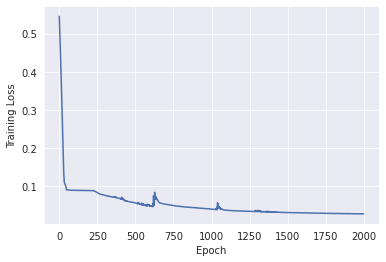

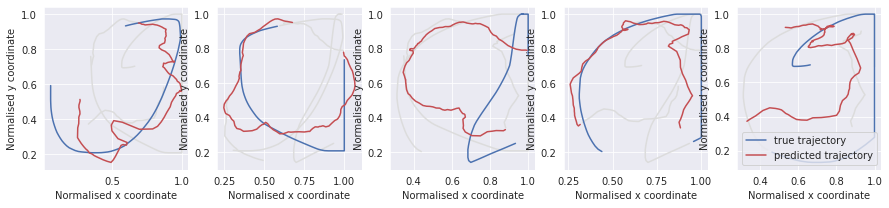

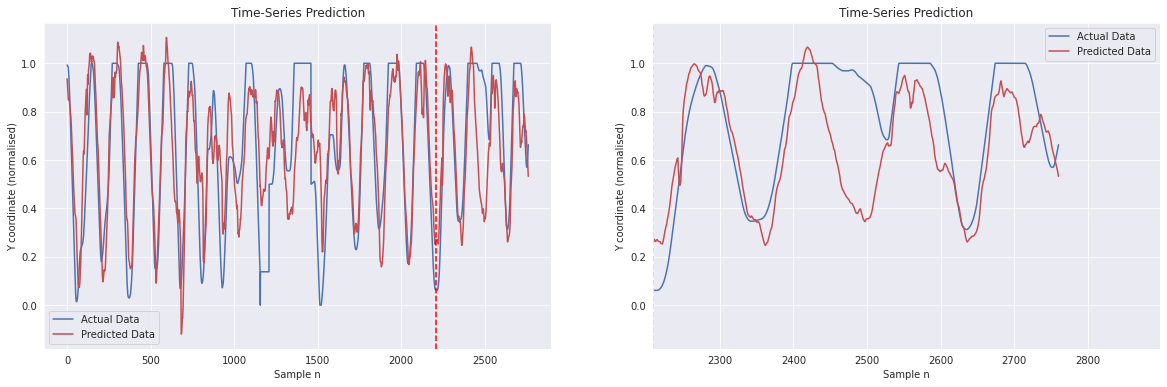

test/train boundary: 2209
test/train proportion: 0.8000724375226367
train length: 552
0.1882013069856878


<Figure size 432x288 with 0 Axes>

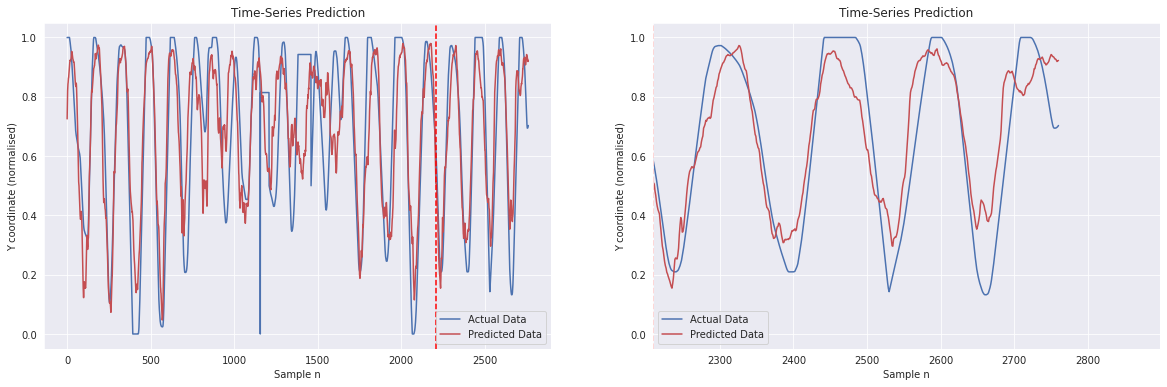

test/train boundary: 2209
test/train proportion: 0.8000724375226367
train length: 552
0.1632007473983247
Final rms:  0.17876470782512902


<Figure size 432x288 with 0 Axes>

In [65]:
plot_losses(train_loss, test_loss)

true_x_test, true_y_test, preds_x_test, preds_y_test = predict(lstm_x, V, cx, cy, train_test_proportion, test=True)
plot_trajectories(true_x_test, true_y_test, preds_x_test, preds_y_test, nbins=5, shadow=True)



traj_preds = [preds_x_test, preds_y_test]
traj_preds = np.array([item for sublist in traj_preds for item in sublist]).flatten()
traj_true = [true_x_test, true_y_test]
traj_true = np.array([item for sublist in traj_true for item in sublist]).flatten()
final_rms = rms(traj_preds, traj_true)
print("Final rms: ", final_rms)




plot_prediction(true_x, preds_x, train_test_proportion)
plot_prediction(true_y, preds_y, train_test_proportion)


traj_preds = [preds_x_test, preds_y_test]
traj_preds = np.array([item for sublist in traj_preds for item in sublist]).flatten()
traj_true = [true_x_test, true_y_test]
traj_true = np.array([item for sublist in traj_true for item in sublist]).flatten()
final_rms = rms(traj_preds, traj_true)
print("Final rms: ", final_rms)









